In [1]:
# install the follwoing packages in the enviroment:
# python3 -m pip install pandas
# python3 -m pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import json

import os

from read_jsondata import read_jsons

## Hypotheses to be tested

#### As reference values to compare to, we will use demographics from ECS from AGU and EGU. This will give an idea of how many of the active scientists at these professional levels are represented to the peer-reviewed articles (which is the main crucial factor for career advancing and perhaps the daily goal of most academics)

FIRST GLANCES AT DATA

- % of female first authors (hists?)
- % publications with all male vs. % publications with all female authors (hists?)

CO-AUTHORSHIP ANALYSES

- When 1st author is female: % of male vs. female co-authors (bars..?)
- When 1st author is female: likelihood of last author (possibly PI) to be female vs. male 
- When 1st author is male: % of female coauthors and % of male coauthors
- When the last name is female (possible PI), is there a higher % of female co-authors vs. male ones?

JOURNAL IF ANALYSES:

- Correlation between IF and female first authors: does higher IF mean fewer female first authors?




In [2]:
# Define local paths

root = ! pwd
root = root[0]

RAW_DIR=root+"/author_allgenders/"  

if not os.path.exists(RAW_DIR):
    print("The directory {} does not exist.\nThere is no raw data for statistical analysis.".format(RAW_DIR))

In [3]:
df = read_jsons(RAW_DIR)
display(df)

,year,journal,all_genders,all_percent
0,2015,GEOPHYSICS,"[male, male, male, male]","[0.98, 0.98, 0.99, 0.98]"
1,2011,G3,"[female, male, male, male]","[0.99, 0.98, 0.98, 0.95]"
2,2011,Bulletin+of+the+Seismological+Society+of+America,"[male, female, female]","[0.67, 0.63, 0.5042013788647864]"
3,2013,JGRSolidEarth,"[male, female, male, male, male]","[0.98, 0.98, 0.99, 0.69, 0.99]"
4,2011,E%26PSL,"[male, male, male, male, male]","[0.98, 0.99, 0.98, 0.99, 0.99]"
...,...,...,...,...
19355,2014,E%26PSL,"[male, male]","[1.0, 1.0]"
19356,2018,E%26PSL,"[male, male, female, male]","[0.93, 0.99, 0.98, 0.97]"
19357,2013,JGRSolidEarth,"[female, female, male, female]","[0.98, 0.99, 0.98, 0.97]"
19358,2016,Bulletin+of+the+Seismological+Society+of+America,"[male, male, male, male]","[0.74, 0.99, 0.99, 0.98]"


In [4]:
# clean some journal names

df.loc[df.journal=='E%26PSL','journal'] = 'EPSL'

df.loc[df.journal.str.contains("Bulletin"),'journal'] = 'BSSA'

df.loc[df.journal.str.contains("Seismological"),'journal'] = 'SRL'

# Include impact factor:

dict_IF = {'Nature': 46.486, 'Science': 41.845, 'NatureGeoscience': 16.103, 'EPSL': 4.823, 'GRL': 4.952, 
        'JGRSolidEarth': 4.191, 'G3': 3.721, 'SRL': 3.131, 'Tectp': 3.048, 'SolidEarth': 2.921, 
       'GEOPHYSICS': 3.093, 'GJI': 2.834, 'BSSA': 2.274, 'PEPI': 2.413}

df['IF'] = df['journal'].map(dict_IF)
df

,year,journal,all_genders,all_percent,IF
0,2015,GEOPHYSICS,"[male, male, male, male]","[0.98, 0.98, 0.99, 0.98]",3.093
1,2011,G3,"[female, male, male, male]","[0.99, 0.98, 0.98, 0.95]",3.721
2,2011,BSSA,"[male, female, female]","[0.67, 0.63, 0.5042013788647864]",2.274
3,2013,JGRSolidEarth,"[male, female, male, male, male]","[0.98, 0.98, 0.99, 0.69, 0.99]",4.191
4,2011,EPSL,"[male, male, male, male, male]","[0.98, 0.99, 0.98, 0.99, 0.99]",4.823
...,...,...,...,...,...
19355,2014,EPSL,"[male, male]","[1.0, 1.0]",4.823
19356,2018,EPSL,"[male, male, female, male]","[0.93, 0.99, 0.98, 0.97]",4.823
19357,2013,JGRSolidEarth,"[female, female, male, female]","[0.98, 0.99, 0.98, 0.97]",4.191
19358,2016,BSSA,"[male, male, male, male]","[0.74, 0.99, 0.99, 0.98]",2.274


### Create new columns in the dataframe extracting useful information from list of coauthors

In [5]:
# Number of authors:

df['Number_authors'] = df['all_genders'].apply(lambda x: len(x)) #take the length of the list all_genders

# First author's gender and percentage:

df['First_Author_gend'] = df['all_genders'].apply(lambda x: x[0]) #take the first element of the list all_genders
df['First_Author_perc'] = df['all_percent'].apply(lambda x: x[0])

# Last author's gender and percentage:

df['Last_Author_gend'] = df['all_genders'].apply(lambda x: x[-1]) #take the last element of the list all_genders
df['Last_Author_perc'] = df['all_percent'].apply(lambda x: x[-1])

df

,year,journal,all_genders,all_percent,IF,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc
0,2015,GEOPHYSICS,"[male, male, male, male]","[0.98, 0.98, 0.99, 0.98]",3.093,4,male,0.98,male,0.980000
1,2011,G3,"[female, male, male, male]","[0.99, 0.98, 0.98, 0.95]",3.721,4,female,0.99,male,0.950000
2,2011,BSSA,"[male, female, female]","[0.67, 0.63, 0.5042013788647864]",2.274,3,male,0.67,female,0.504201
3,2013,JGRSolidEarth,"[male, female, male, male, male]","[0.98, 0.98, 0.99, 0.69, 0.99]",4.191,5,male,0.98,male,0.990000
4,2011,EPSL,"[male, male, male, male, male]","[0.98, 0.99, 0.98, 0.99, 0.99]",4.823,5,male,0.98,male,0.990000
...,...,...,...,...,...,...,...,...,...,...
19355,2014,EPSL,"[male, male]","[1.0, 1.0]",4.823,2,male,1.00,male,1.000000
19356,2018,EPSL,"[male, male, female, male]","[0.93, 0.99, 0.98, 0.97]",4.823,4,male,0.93,male,0.970000
19357,2013,JGRSolidEarth,"[female, female, male, female]","[0.98, 0.99, 0.98, 0.97]",4.191,4,female,0.98,female,0.970000
19358,2016,BSSA,"[male, male, male, male]","[0.74, 0.99, 0.99, 0.98]",2.274,4,male,0.74,male,0.980000


 #### It is easier if the all probabilities are with respect to the same gender (female)

In [6]:
# prob(female) = 1 - prob(male)

# Prob last author female:

df['Last_Author_probF'] = df['Last_Author_perc']
df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF'] = \
    1 - df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF']

# Prob first author female:

df['First_Author_probF'] = df['First_Author_perc']
df.loc[df['First_Author_gend'] == 'male','First_Author_probF'] = \
    1 - df.loc[df['First_Author_gend'] == 'male','First_Author_probF']

df

,year,journal,all_genders,all_percent,IF,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF
0,2015,GEOPHYSICS,"[male, male, male, male]","[0.98, 0.98, 0.99, 0.98]",3.093,4,male,0.98,male,0.980000,0.020000,0.02
1,2011,G3,"[female, male, male, male]","[0.99, 0.98, 0.98, 0.95]",3.721,4,female,0.99,male,0.950000,0.050000,0.99
2,2011,BSSA,"[male, female, female]","[0.67, 0.63, 0.5042013788647864]",2.274,3,male,0.67,female,0.504201,0.504201,0.33
3,2013,JGRSolidEarth,"[male, female, male, male, male]","[0.98, 0.98, 0.99, 0.69, 0.99]",4.191,5,male,0.98,male,0.990000,0.010000,0.02
4,2011,EPSL,"[male, male, male, male, male]","[0.98, 0.99, 0.98, 0.99, 0.99]",4.823,5,male,0.98,male,0.990000,0.010000,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
19355,2014,EPSL,"[male, male]","[1.0, 1.0]",4.823,2,male,1.00,male,1.000000,0.000000,0.00
19356,2018,EPSL,"[male, male, female, male]","[0.93, 0.99, 0.98, 0.97]",4.823,4,male,0.93,male,0.970000,0.030000,0.07
19357,2013,JGRSolidEarth,"[female, female, male, female]","[0.98, 0.99, 0.98, 0.97]",4.191,4,female,0.98,female,0.970000,0.970000,0.98
19358,2016,BSSA,"[male, male, male, male]","[0.74, 0.99, 0.99, 0.98]",2.274,4,male,0.74,male,0.980000,0.020000,0.26


## Now we can compute some interesting probabilities:

### Useful formulas:

Suppose $x_i$ refers to the article $i$ and $N$ is the total number of articles. Then, the probability of an article having female author is:

$$p(\text{female}) = \sum_{i}^N p(\text{female}|x_i) p(x_i). $$

If we have all the probabilities with respect to the female gender, then the probability of having a male author will be:

$$p(\text{male}) = \sum_{i}^N (1 - p(\text{female}|x_i)) p(x_i). $$

$p(x_i)$ is the probability of the article $x_i$. All articles have the same probability, therefore $p(x_i) = \frac{1}{N}$. This means that the formulas above are same as taking the average of  $p(\text{female}|x_i)$ or $(1 - p(\text{female}|x_i))$, respectively.


### Let's compute some easy statistics to start

In [7]:
print('Probability of having a female first author:', df['First_Author_probF'].sum()/df.shape[0])
print('Probability of having a male first author:', (1 - df['First_Author_probF']).sum()/df.shape[0])


print('Probability of having a female last author:', df['Last_Author_probF'].sum()/df.shape[0])
print('Probability of having a male last author:', (1 - df['Last_Author_probF']).sum()/df.shape[0])



Probability of having a female first author: 0.26617682599020004
Probability of having a male first author: 0.6995773062412051
Probability of having a female last author: 0.1847974917220097
Probability of having a male last author: 0.7800785413358415


#### Probabilities of having at least one male/female author in an article

Having at least one female author refers to any coauthor combination excluding the case in which all authors are male:

$$p(\text{at least 1 female}|x_i) = 1 - p(\text{all male}|x_i)$$

Computing probability for all male coauthors is easier. In the following, we drop the dependency on $x_i$ for clarity.

$$p(\text{all male}) = p(\text{male}_1)p(\text{male}_2|\text{male}_1)p(\text{male}_3|\text{male}_1,\text{male}_2)... = \prod_i^n p(\text{male}_i)$$

where n is the number of authors and the last step assumes that the gender probability of each authorship is independent of the gender of other coauthors (just to simplify the problem). 

In [8]:
#Define functions to multiply probabilities in each row

#prob at least a female author

def Prob_atleast_Fauthor(x,y):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= float(y[i]) 
        elif elem == 'female':
            prod *= 1 - float(y[i])
    return 1 - prod

#prob at least a male author

def Prob_atleast_Mauthor(x,y):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= 1 - float(y[i]) 
        elif elem == 'female':
            prod *= float(y[i])
    return 1 - prod


# Create corresponding columns:

df['Prob_atleast_Fauthor'] = df.apply(lambda x: Prob_atleast_Fauthor(x.all_genders, x.all_percent), axis=1)
df['Prob_atleast_Mauthor'] = df.apply(lambda x: Prob_atleast_Mauthor(x.all_genders, x.all_percent), axis=1)

df

,year,journal,all_genders,all_percent,IF,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF,Prob_atleast_Fauthor,Prob_atleast_Mauthor
0,2015,GEOPHYSICS,"[male, male, male, male]","[0.98, 0.98, 0.99, 0.98]",3.093,4,male,0.98,male,0.980000,0.020000,0.02,0.068220,1.000000
1,2011,G3,"[female, male, male, male]","[0.99, 0.98, 0.98, 0.95]",3.721,4,female,0.99,male,0.950000,0.050000,0.99,0.990876,0.999980
2,2011,BSSA,"[male, female, female]","[0.67, 0.63, 0.5042013788647864]",2.274,3,male,0.67,female,0.504201,0.504201,0.33,0.877092,0.895177
3,2013,JGRSolidEarth,"[male, female, male, male, male]","[0.98, 0.98, 0.99, 0.69, 0.99]",4.191,5,male,0.98,male,0.990000,0.010000,0.02,0.986745,0.999999
4,2011,EPSL,"[male, male, male, male, male]","[0.98, 0.99, 0.98, 0.99, 0.99]",4.823,5,male,0.98,male,0.990000,0.010000,0.02,0.068125,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19355,2014,EPSL,"[male, male]","[1.0, 1.0]",4.823,2,male,1.00,male,1.000000,0.000000,0.00,0.000000,1.000000
19356,2018,EPSL,"[male, male, female, male]","[0.93, 0.99, 0.98, 0.97]",4.823,4,male,0.93,male,0.970000,0.030000,0.07,0.982138,0.999979
19357,2013,JGRSolidEarth,"[female, female, male, female]","[0.98, 0.99, 0.98, 0.97]",4.191,4,female,0.98,female,0.970000,0.970000,0.98,0.999994,0.981178
19358,2016,BSSA,"[male, male, male, male]","[0.74, 0.99, 0.99, 0.98]",2.274,4,male,0.74,male,0.980000,0.020000,0.26,0.289231,0.999999


In [15]:
## Remove rows for papers from 2021

df = df[~df['year'].isin(['2021'])]
df

,year,journal,all_genders,all_percent,IF,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF,Prob_atleast_Fauthor,Prob_atleast_Mauthor,P_atleast_F_journal,P_atleast_M_journal,P_atleast_F_year,P_atleast_M_year
0,2015,GEOPHYSICS,"[male, male, male, male]","[0.98, 0.98, 0.99, 0.98]",3.093,4,male,0.98,male,0.980000,0.020000,0.02,0.068220,1.000000,0.434066,0.980851,0.554131,0.964190
1,2011,G3,"[female, male, male, male]","[0.99, 0.98, 0.98, 0.95]",3.721,4,female,0.99,male,0.950000,0.050000,0.99,0.990876,0.999980,0.666923,0.978781,0.503570,0.958942
2,2011,BSSA,"[male, female, female]","[0.67, 0.63, 0.5042013788647864]",2.274,3,male,0.67,female,0.504201,0.504201,0.33,0.877092,0.895177,0.565827,0.957073,0.503570,0.958942
3,2013,JGRSolidEarth,"[male, female, male, male, male]","[0.98, 0.98, 0.99, 0.69, 0.99]",4.191,5,male,0.98,male,0.990000,0.010000,0.02,0.986745,0.999999,0.603106,0.971520,0.556419,0.961877
4,2011,EPSL,"[male, male, male, male, male]","[0.98, 0.99, 0.98, 0.99, 0.99]",4.823,5,male,0.98,male,0.990000,0.010000,0.02,0.068125,1.000000,0.634317,0.982283,0.503570,0.958942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19355,2014,EPSL,"[male, male]","[1.0, 1.0]",4.823,2,male,1.00,male,1.000000,0.000000,0.00,0.000000,1.000000,0.634317,0.982283,0.555049,0.967797
19356,2018,EPSL,"[male, male, female, male]","[0.93, 0.99, 0.98, 0.97]",4.823,4,male,0.93,male,0.970000,0.030000,0.07,0.982138,0.999979,0.634317,0.982283,0.613181,0.975033
19357,2013,JGRSolidEarth,"[female, female, male, female]","[0.98, 0.99, 0.98, 0.97]",4.191,4,female,0.98,female,0.970000,0.970000,0.98,0.999994,0.981178,0.603106,0.971520,0.556419,0.961877
19358,2016,BSSA,"[male, male, male, male]","[0.74, 0.99, 0.99, 0.98]",2.274,4,male,0.74,male,0.980000,0.020000,0.26,0.289231,0.999999,0.565827,0.957073,0.585799,0.975083


In [10]:
print('Probability of having at least one female author in an article', 
      df['Prob_atleast_Fauthor'].sum()/df.shape[0])

print('Probability of having at least one male author in an article', 
      df['Prob_atleast_Mauthor'].sum()/df.shape[0])

print('or the opposite...')

print('Probability of having at all female authors in an article', 
      1 - df['Prob_atleast_Mauthor'].sum()/df.shape[0])

print('Probability of having at all male authors in an article', 
      1 - df['Prob_atleast_Fauthor'].sum()/df.shape[0])

Probability of having at least one female author in an article 0.5747392473319695
Probability of having at least one male author in an article 0.9665561969487355
or the opposite...
Probability of having at all female authors in an article 0.03344380305126449
Probability of having at all male authors in an article 0.42526075266803054


#### We can compute the same quantity per each journal

In [11]:

journals = df['journal'].unique() # a list of unique journal names

df['P_atleast_F_journal'] = df['Prob_atleast_Fauthor'] #initialize the columns
df['P_atleast_M_journal'] = df['Prob_atleast_Mauthor']

for i in journals: #update values for each journal
    cond = df['journal']==i
    print("N = ", len(df[cond].values), " for journal ", i)
    df.loc[cond,'P_atleast_F_journal'] = df.loc[cond,'Prob_atleast_Fauthor'].sum()/df[cond].shape[0]
    df.loc[cond,'P_atleast_M_journal'] = df.loc[cond,'Prob_atleast_Mauthor'].sum()/df[cond].shape[0]
    

N =  1808  for journal  GEOPHYSICS
N =  859  for journal  G3
N =  2207  for journal  BSSA
N =  3367  for journal  JGRSolidEarth
N =  1364  for journal  EPSL
N =  519  for journal  PEPI
N =  2272  for journal  GRL
N =  1835  for journal  Tectp
N =  2789  for journal  GJI
N =  1576  for journal  SRL
N =  89  for journal  Science
N =  254  for journal  SolidEarth
N =  188  for journal  NatureGeoscience
N =  62  for journal  Nature


/Users/mariak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mariak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/mariak/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

##### Make bar plots

(0.0, 1.0)

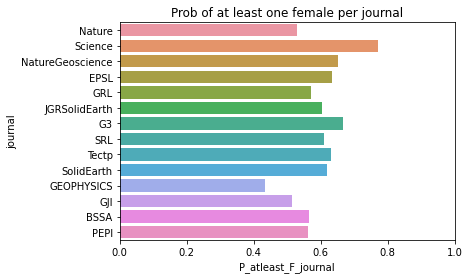

In [12]:
sns.barplot(y="journal", x="P_atleast_F_journal",  data=df, order=dict_IF.keys()).set_title('Prob of at least one female per journal')
plt.xlim([0,1])

(0.0, 1.0)

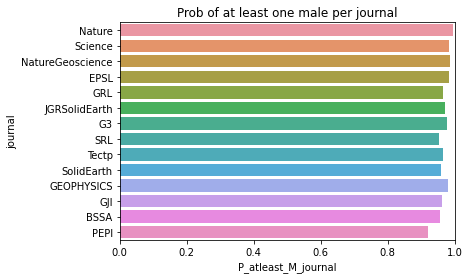

In [13]:
sns.barplot(y="journal", x="P_atleast_M_journal",  data=df, order=dict_IF.keys()).set_title('Prob of at least one male per journal')
plt.xlim([0,1])

#### See the temporal trend of having at least one F or one M in a publication for all journals per year


In [14]:
years = df['year'].unique() # a list of unique journal names
years.sort()
print(years)

for i in years: #update values for each journal
    cond = df['year']==i
    print("Number of articles = ", len(df[cond].values), " for year ", i)
    df.loc[cond,'P_atleast_F_year'] = df.loc[cond,'Prob_atleast_Fauthor'].sum()/df[cond].shape[0]
    df.loc[cond,'P_atleast_M_year'] = df.loc[cond,'Prob_atleast_Mauthor'].sum()/df[cond].shape[0]



['2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019'
 '2020']
Number of articles =  1460  for year  2010
Number of articles =  1344  for year  2011
Number of articles =  1453  for year  2012
Number of articles =  1750  for year  2013
Number of articles =  1658  for year  2014
Number of articles =  1704  for year  2015
Number of articles =  1863  for year  2016
Number of articles =  1787  for year  2017
Number of articles =  2011  for year  2018
Number of articles =  1899  for year  2019
Number of articles =  2260  for year  2020


/Users/mariak/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariak/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
sns.barplot(y="year", x="P_atleast_F_year",  data=df, order=years).set_title('Prob of at least one female all journals per year')
plt.xlim([0,1])

In [ ]:
sns.barplot(y="year", x="P_atleast_M_year",  data=df, order=years).set_title('Prob of at least one male all journals per year')
plt.xlim([0,1])

#### Female & male percentages per year 

In [ ]:
last_auth_F_year = df.groupby(['year'])['Last_Author_gend'].apply(lambda x: x[x.str.contains('female')].count())
print(last_auth_F_year)

last_auth_M_year = df.groupby(['year'])['Last_Author_gend'].apply(lambda x: x[x.str.contains('male')].count())
print(last_auth_M_year)

first_auth_F_year = df.groupby(['year'])['First_Author_gend'].apply(lambda x: x[x.str.contains('female')].count())
print(first_auth_F_year)

first_auth_M_year = df.groupby(['year'])['First_Author_gend'].apply(lambda x: x[x.str.contains('male')].count())
print(first_auth_M_year)




#### We should check if the numbers above are biased or are a consequence of female/male author distribution.

We can generate synthetic data using the distribution of female/male authors.


#### 1. Probability of an author being female/male:

In [ ]:
def Prob_atleastauthor(x,y, kind="female", allkinds="malefemale"):
    sum = 0
    for i,elem in enumerate(x):
        if elem not in allkinds:
            continue
        if elem != kind:
            sum += 1 - float(y[i]) 
        elif elem == kind:
            sum += float(y[i])
    return sum

# def Prob_Mauthor(x,y):
#     sum = 0
#     for i,elem in enumerate(x):
#         if elem == 'male':
#             sum += float(y[i]) 
#         elif elem == 'female':
#             sum += 1 - float(y[i])
#     return sum

df['Prob_Fauthor'] = df.apply(lambda x: Prob_atleastauthor(x.all_genders, x.all_percent, "female"), axis=1)
df['Prob_Mauthor'] = df.apply(lambda x: Prob_atleastauthor(x.all_genders, x.all_percent, "male"), axis=1)

df

#### 2. Create some synthetic genders for authors:

In [ ]:
### Define a random sampler from the distribution of female/male authors:

elements = ['female', 'male', 'init']
p1 = df['Prob_Fauthor'].sum()/df['Number_authors'].sum() #prob of an author being female
p2 = df['Prob_Mauthor'].sum()/df['Number_authors'].sum() #prob of an author being male
p3 = 1 - p1 - p2 #prob of an author being init

probabilities = [p1, p2 , p3]
np.random.choice(elements, 10, p=probabilities) # example: take 10 random samples

In [ ]:
# Generate synthetic genders per each article maintaining the number of authors:

df['Synth_genders'] = df['Number_authors'].apply(lambda x: np.random.choice(elements, x, p=probabilities))
df

In [ ]:
### Now check for these synthetics the probabilities:

# prob having at least one female author

def Prob_atleast_Fauthor_synth(x):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= 1 
        elif elem == 'female':
            prod *= 0
    return 1 - prod

df['Prob_atleast_Fauthor_synth'] = df.apply(lambda x: Prob_atleast_Fauthor_synth(x.Synth_genders), axis=1)

print('Probability of having at least one female author in an article', 
      df['Prob_atleast_Fauthor_synth'].sum()/df.shape[0])

# prob having at least one male author

def Prob_atleast_Mauthor_synth(x):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= 0
        elif elem == 'female':
            prod *= 1
    return 1 - prod

df['Prob_atleast_Mauthor_synth'] = df.apply(lambda x: Prob_atleast_Mauthor_synth(x.Synth_genders), axis=1)

print('Probability of having at least one male author in an article',
      df['Prob_atleast_Mauthor_synth'].sum()/df.shape[0])


In [ ]:
### What is the prob of first and last authorships?


df['First_Author_Fperc_synth'] = df['Synth_genders'].apply(lambda x: 1 if x[0]=='female' else 0)
df['First_Author_Mperc_synth'] = df['Synth_genders'].apply(lambda x: 1 if x[0]=='male' else 0)

df['Last_Author_Fperc_synth'] = df['Synth_genders'].apply(lambda x: 1 if x[-1]=='female' else 0)
df['Last_Author_Mperc_synth'] = df['Synth_genders'].apply(lambda x: 1 if x[-1]=='male' else 0)

print('First author female:', df['First_Author_Fperc_synth'].sum()/df.shape[0])
print('First author male:', df['First_Author_Mperc_synth'].sum()/df.shape[0])
print('Last author female:', df['Last_Author_Fperc_synth'].sum()/df.shape[0])
print('Last author male:', df['Last_Author_Mperc_synth'].sum()/df.shape[0])
